# AST 384C - Computational Astrophysics - HW 1
## Carlos Jurado

In [1]:
# Python package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import timeit
from tqdm import tqdm
import time

# Loading in style file for plots
plt.style.use('/Users/caj3577/Desktop/plotting.mplstyle')

# Problem 1

The standard Kepler problem is the bound orbit of a test particle around a body of mass M. The
equations are:

$$ 
\boldsymbol{\dot{r}} = \boldsymbol{v}
$$

$$
\boldsymbol{\dot{v}} = \frac{GM}{r^3}\boldsymbol{r}
$$

where r = (x, y) and v = (vx, vy). Initialize the system with the particle at (0, rp ) with velocity
(−vp, 0), which puts the particle moving counterclockwise with velocity vp at pericenter rp.

For this homework, assume the orbit is that of a planet at the Earth-Sun separation (a = 1 AU)
around central mass with M = 1 M⊙

- Implement a 4th-order Runge-Kutta solver with fixed timestep to solve the Kepler problem.
First, apply this to a circular orbit (e = 0) over a 1 year period. Compare results for a
timestep of 1 month (1/12 of a period), 1 week (you can approximate this as 1/48 of a
period for this exercise), and 1 day (1/365.25 of a period). Relative to the initial value, how
does the error in the final position depend on the timestep? How about the error in the
energy?

In [2]:
class KeplerOrbit:
    ''' 
    Sets-up and tracks a particle in a Keplerian orbit and it's subsequent time evolution. 

    Attributes:
        state (np.array): The current phase-space state vector in cartesian coordinates -- [x,y,vx,vy]
        GM (float): Gravitational Constant multiplied by the mass of the central body ( [M] in Solar Masses, [T] in Years, [L] in AU )
        state_history (np.arry): A (N,4,1) np.array of all previous and the current phase-state vectors at a given time

    Methods:
    
        __init__ 
            Initializes a KeplerOrbit object with state and GM attributes.         
             

        specfic_energy
            Calculates the specific energy of the orbiting body at the current state

            Return: (float)


        positional_derivative: 
            Calculates the velocity of the orbiting body at the current state

            Parameters:
                State ( np.array of shape (4,1) ): The current phase-space state of the particle

            Return: ( np.array of shape (2,1) )

            
        velocity_derivative: 
            Calculates the acceleration of the orbiting body at the current state

            Parameters:
                State ( np.array of shape (4,1) ): The current phase-space state of the particle

            Return: ( np.array of shape (2,1) )

            
        RK4: 
            Fourth-order Runge-Kutta Implementation to track a point-mass particle's trajectory.
            At the end of one iteration, the current state and history of the object is updated. 
            
            Parameters: 
                dt: The amount of time to evolve the system forward 
                N: The number of intervals to evavluate the particle's position at 

        
        xyvxvy_history: 
            Splits the state_history variable into separate components for each coordinate (x,y,vx,vz) 

        Return: (    np.array of Shape (N), np.array of Shape (N), np.array of Shape (N), np.array of Shape (N)    )          
    '''


    def __init__(self, initial_state, GM):
        self.state = np.array(initial_state, dtype=np.float64)
        self.GM = GM
        self.state_history = [self.state]


    def specific_energy(self):
        position_arr, velocity_arr = self.state[0:2], self.state[2:] #Splits state vector into a position vector and velocity vector

        r = np.sqrt(position_arr[0]**2 + position_arr[1]**2) #radius of the particle from the central body
        v = np.sqrt(velocity_arr[0]**2 + velocity_arr[1]**2) #speed of the particle 

        return 0.5*(v**2) - (self.GM)/r #Total Energy


    def positional_derivative(self, state): 
        return state[2:] #dx/dt = v
    
     
    def velocity_derivative(self, state):
        r = np.sqrt( state[0]**2 + state[1]**2  ) #radius of the particle from the central body
        return -self.GM/(r**3) * state[0:2] # Vector form: dv/dt = -GM/r^3 <x, y> 


    def RK4(self, N, start_time, end_time):
        dt = (end_time - start_time)/N
        for i in range(N):

            k1vel = dt*self.velocity_derivative(self.state) 
            k1pos = dt*self.positional_derivative(self.state)

            
            k2vel = dt*self.velocity_derivative( self.state + 0.5*np.concatenate( (k1pos, k1vel), axis=0 ) )
            k2pos = dt*self.positional_derivative( self.state + 0.5*np.concatenate( (k1pos, k1vel), axis=0 ) )

            k3vel = dt*self.velocity_derivative( self.state + 0.5*np.concatenate( (k2pos, k2vel), axis=0 ) )
            k3pos = dt*self.positional_derivative( self.state + 0.5*np.concatenate( (k2pos, k2vel), axis=0 ) )


            k4vel = dt*self.velocity_derivative( self.state + np.concatenate( (k3pos, k3vel), axis=0 ) )
            k4pos = dt*self.positional_derivative( self.state + np.concatenate( (k3pos, k3vel), axis=0 ) )


            k1 = np.concatenate((k1pos, k1vel))
            k2 = np.concatenate((k2pos, k2vel))
            k3 = np.concatenate((k3pos, k3vel))
            k4 = np.concatenate((k4pos, k4vel))

            self.state += (1/6)*(k1+2*k2+2*k3+k4) #update state of the particle according to the 4th order Runge-Kutta weighing
            self.state_history.append(self.state.copy()) #append current state to history



    def xyvxvy_history(self):
        state_array = np.array(self.state_history)
        
        # Split the array into separate components
        x_history = state_array[:, 0]
        y_history = state_array[:, 1]
        vx_history = state_array[:, 2]
        vy_history = state_array[:, 3]
        
        return x_history, y_history, vx_history, vy_history

In [33]:
def velocity(GM, a, e): 
    ''' 
    Calculates velocity of a point particle at perihelion 
    '''
    return np.sqrt(GM/a) * np.sqrt( (1+e)/(1-e) )


#Initial Condtion Setup
###
e_initial = 0
a_intial = 1 * (1-e_initial)
GM = 4 * np.pi**2 
start_time, end_time = 0,1
###


#Initial State Setup
###
v_initial = - velocity(GM, a_intial, e_initial)
initial_state = np.array([0,a_intial,v_initial,0])  
###


'''
N_12 = 12 # number of intervals
orbitN12 = KeplerOrbit(initial_state, GM=4*np.pi**2) #Initialize orbit
orbitN12.RK4(N_12, start_time, end_time) #Integrate orbit
dynamical_historyN12 = orbitN12.xyvxvy_history() #Access state vector at each time step
'''


N_values = [12, 48, 365]  # Array of N values to explore. Here each N refers to the numbers of steps taken in 1 year
orbit_histories = {}  

for N in N_values:
    orbit = KeplerOrbit(initial_state, GM)  # Reset the orbit for each N
    orbit.RK4(N, start_time, end_time)  # Evolve the system
    orbit_histories[N] = orbit.xyvxvy_history()  # Store the history


In [34]:
### Error Calculations

#Error between initial and final position 

positional_err = {}
for N in N_values: 
    positional_err[N] = np.abs(orbit_histories[N][1][-1]/initial_state[1] - 1) #relative error = (final_val - initial_val)/initial_val = final_val/inital_val - 1

(1e-10, 0.05)

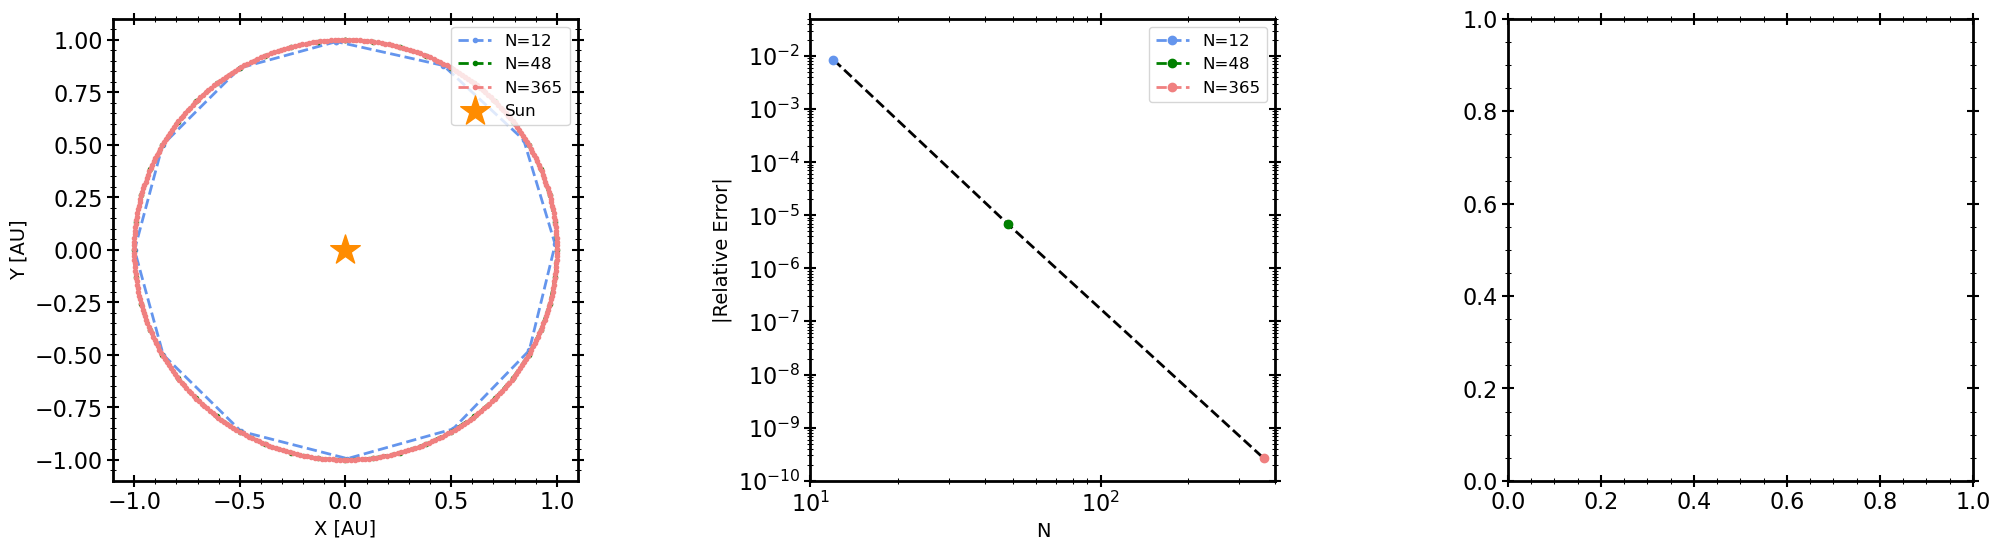

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

axs[0].plot(orbit_histories[12][0], orbit_histories[12][1], color='cornflowerblue', marker='.', label='N=12', linestyle = '--')
axs[0].plot(orbit_histories[48][0], orbit_histories[48][1], color='green', marker='.', label='N=48', linestyle = '--')
axs[0].plot(orbit_histories[365][0], orbit_histories[365][1], color='lightcoral', marker='.', label='N=365', linestyle = '--')
axs[0].scatter(0, 0, marker = '*', color = 'darkorange', s=500, label='Sun')

axs[0].set_xlabel('X [AU]')
#axs[0].set_xlim(-1.2, 1.2)

axs[0].set_ylabel('Y [AU]')
#axs[0].set_ylim(-1.2, 1.2)
axs[0].legend(ncol=1, loc='upper right')






axs[1].loglog(N_values, [positional_err[12], positional_err[48], positional_err[365]], color='black', linestyle = '--')
axs[1].loglog(N_values[0], positional_err[12], color='cornflowerblue', marker='o', label='N=12', linestyle = '--')
axs[1].loglog(N_values[1], positional_err[48], color='green', marker='o', label='N=48', linestyle = '--')
axs[1].loglog(N_values[2], positional_err[365], color='lightcoral', marker='o', label='N=365', linestyle = '--')
axs[1].legend(ncol=1, loc='upper right')

axs[1].set_xlabel('N')
axs[1].set_xlim(10**1, 4 * 10**2)
axs[1].set_ylabel('|Relative Error|')
axs[1].set_ylim(10**-10, 5 * 10**-2)